<a href="https://colab.research.google.com/github/elisabyfield/AI-Climate-Change-Prediction-Models/blob/main/AI_Climate_Change_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [ ]:
"""
import kaggle dataset zip file from drive
"""
from google.colab import drive
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from datetime import datetime
import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures


# Unzip file
drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/GlobalTemperatures.csv.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content") # can change path to what works for you

# Load csv
df = pd.read_csv("/content/GlobalTemperatures.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

In [ ]:
# Convert specific numerical columns from Celsius to Fahrenheit (for readability)
def convertTempToFahrenheit(temp):
  return (temp * 1.8) + 32

numerical_colm = ['LandAverageTemperature','LandMaxTemperature','LandMinTemperature','LandAndOceanAverageTemperature']
df[numerical_colm] = df[numerical_colm].applymap(convertTempToFahrenheit)

df[numerical_colm].head()

<ipython-input-2-10c17444fac9>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[numerical_colm] = df[numerical_colm].applymap(convertTempToFahrenheit)


,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
0,37.4612,NaN,NaN,NaN
1,37.5494,NaN,NaN,NaN
2,42.1268,NaN,NaN,NaN
3,47.2820,NaN,NaN,NaN
4,52.8314,NaN,NaN,NaN


In [ ]:
"""
Data Preprocessing
"""
from sklearn.model_selection import train_test_split

df = df.dropna(subset=["LandAndOceanAverageTemperature"]) # take out data with empty values

df['dt'] = pd.to_datetime(df['dt']) # convert to datetime

df['year'] = df['dt'].dt.year # get year from dt datetime column
df['month'] = df['dt'].dt.month

yearly_df = df.groupby(['year', 'month'])[['LandAndOceanAverageTemperature']] # group data by year
yearly_df = yearly_df.mean().reset_index() # calculate mean for each year and reset index
yearly_df.head()


"""
Split into training, testing, and validation sets
Split chronologically not randomly because it is a sequential dataset
"""

split = int(len(yearly_df) * 0.8) # point to split data in 80 | 20 ratio according to year

train_df = yearly_df.iloc[:split] # first 80% goes to training
test_df = yearly_df.iloc[split:] # last 20% goes to testing

# separate features and target
X_train = train_df[['year', 'month']]
y_train = train_df['LandAndOceanAverageTemperature']

X_test = test_df[['year', 'month']]
y_test = test_df['LandAndOceanAverageTemperature']



<ipython-input-3-cc4c1b8f92d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['dt']) # convert to datetime
<ipython-input-3-cc4c1b8f92d6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['dt'].dt.year # get year from dt datetime column
<ipython-input-3-cc4c1b8f92d6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

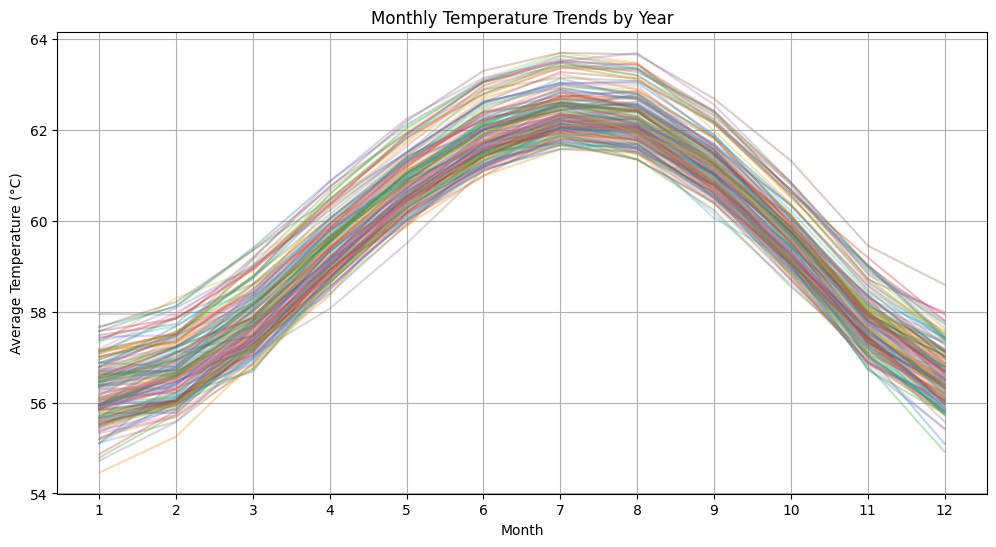

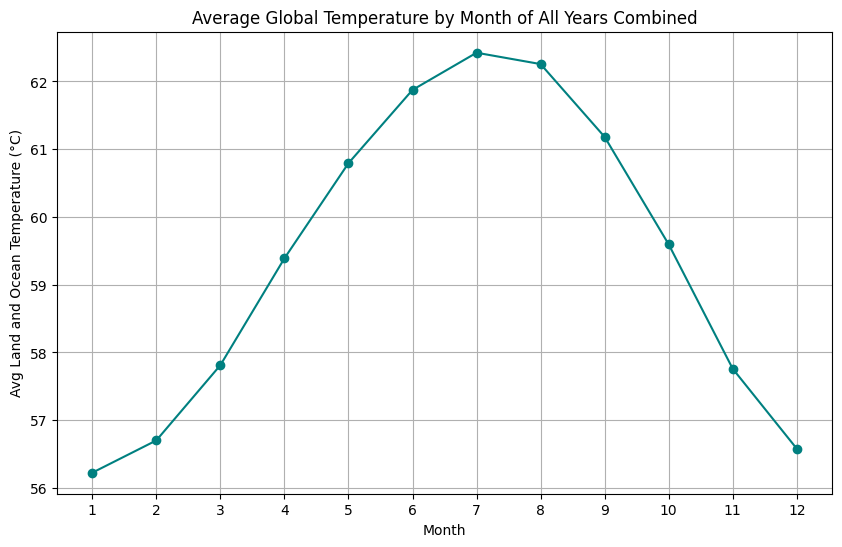

In [ ]:
"""
Exploratory Data Analysis Plots
"""

plt.figure(figsize=(12, 6))

for year in yearly_df['year'].unique():
    yearly = yearly_df[yearly_df['year'] == year]
    plt.plot(yearly['month'], yearly['LandAndOceanAverageTemperature'], label=str(year), alpha=0.3)

plt.title('Monthly Temperature Trends by Year')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already cleaned and has 'month' and 'LandAndOceanAverageTemperature'
monthly_avg = df.groupby('month')['LandAndOceanAverageTemperature'].mean()

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='teal')
plt.title('Average Global Temperature by Month of All Years Combined')
plt.xlabel('Month')
plt.ylabel('Avg Land and Ocean Temperature (°C)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


In [ ]:
"""
Support Vector Machine (SVR) model training
predicts climate change for global land and ocean average temperature
"""

param_grid = {
    'svr__kernel' : ['rbf', 'poly'],
    'svr__C' : [0.1, 1, 10],
    'svr__epsilon' : [0.01, 0.04, 0.05],
    'svr__gamma' : [0.1, 1, 'scale', 'auto']
}

regr = make_pipeline(StandardScaler(), SVR()) # scale for SVR

cv_split = TimeSeriesSplit(n_splits=5) # 5 folds with time series split for cross validation
grid_search_model = GridSearchCV(regr, param_grid, cv=cv_split, scoring='neg_mean_squared_error', verbose=1) # tune the hyperparameters,

grid_search_model.fit(X_train, y_train) # train model on traning data

print("Best SVR Hyperparameters: ", grid_search_model.best_params_) # best performing hyperparameters
bestModel = grid_search_model.best_estimator_ # best model (uses best hyperparameters)

#predict on test set
y_pred= bestModel.predict(X_test)

#evaluate model using metrics
svr_MSE = mean_squared_error(y_test, y_pred)
svr_RMSE = np.sqrt(svr_MSE)
svr_MAE = mean_absolute_error(y_test, y_pred)
svr_R2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE): ", svr_RMSE)
print("Mean Absolute Error (MAE): ", svr_MAE)
print("R-Squared: ", svr_R2)



Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best SVR Hyperparameters:  {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Root Mean Squared Error (RMSE):  0.5725165468449961
Mean Absolute Error (MAE):  0.42416767000726596
R-Squared:  0.9330240333504439


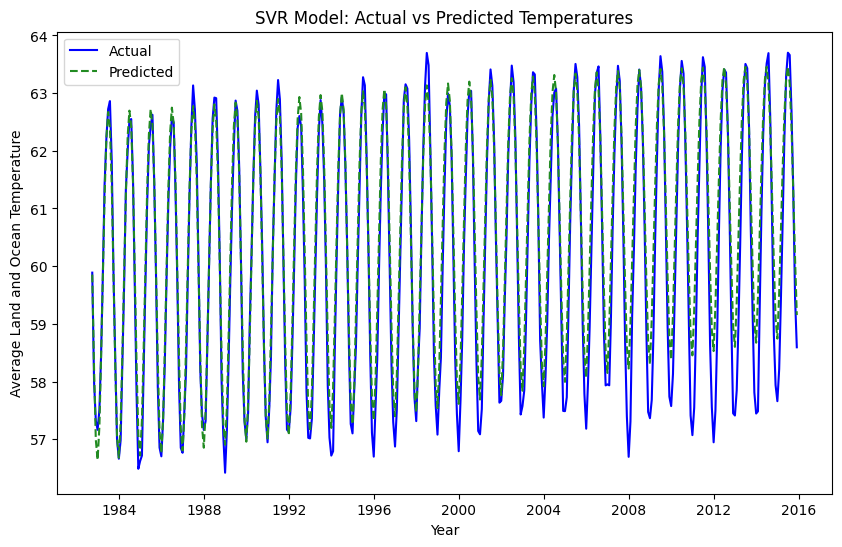

NameError: name 'best_model' is not defined

In [ ]:
"""
SVR plots
"""

# Actual VS Predicted Temperatures
X_test_dates = [datetime(year, month, 1) for year, month in zip(test_df['year'], test_df['month'])]

plt.figure(figsize=(10, 6))
plt.plot(X_test_dates, y_test, label="Actual", color='blue')
plt.plot(X_test_dates, y_prediction, label="Predicted", color='forestgreen', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Average Land and Ocean Temperature')
plt.title('SVR Model: Actual vs Predicted Temperatures')
plt.legend()
plt.show()

# Hyperparameter

# Model on just training data
y_train_pred = best_model.predict(X_train)

# If X_train is time-based (like years), extract it as 1D
# Adjust this depending on your data format
time_axis = X_train.ravel() if X_train.shape[1] == 1 else np.arange(len(X_train))

# Plot actual vs. predicted temperature
plt.figure(figsize=(10, 6))
plt.plot(time_axis, y_train, label="Actual", color="blue")
plt.plot(time_axis, y_train_pred, label="Predicted", color="red", linestyle='--')
plt.title("SVR Model Predictions on Training Data")
plt.xlabel("Time")
plt.ylabel("Temperature Anomaly")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training Random Forest model...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Training completed in 492.60 seconds
Best Random Forest Hyperparameters:  {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200}

Random Forest Model Evaluation:
Root Mean Squared Error (RMSE):  0.6316984038920053
Mean Absolute Error (MAE):  0.5341745087812001
R-Squared:  0.9184615477969797


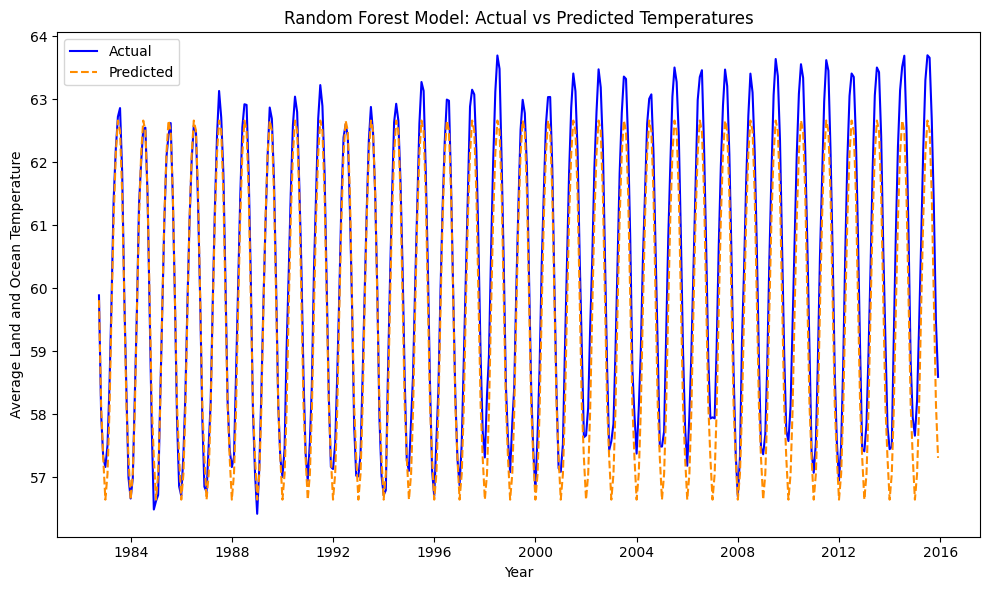

In [ ]:
"""
Random Forest model training
"""

# record start time for performance tracking
start_time = time.time()

# define parameter grid for RandomForestRegressor
# the 'auto' is replaced with 'sqrt' as 'auto'
rf_param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [None, 10, 20, 30],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__max_features': ['sqrt', 'log2', None]  #use None
}

# create pipeline
rf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))

# timeSeriesSplit for cross-validation
timeSeries_cv = TimeSeriesSplit(n_splits=5)

# grid search with time series cross-validation
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=timeSeries_cv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # use all available cores
)

# fit the model
print("Training Random Forest model...")
rf_grid_search.fit(X_train, y_train)

# give training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# get best parameters and model
print("Best Random Forest Hyperparameters: ", rf_grid_search.best_params_)
rf_best_model = rf_grid_search.best_estimator_

# predict on test set
rf_y_prediction = rf_best_model.predict(X_test)

# model evaluation
rf_MSE = mean_squared_error(y_test, rf_y_prediction)
rf_RMSE = np.sqrt(rf_MSE)
rf_MAE = mean_absolute_error(y_test, rf_y_prediction)
rf_R2 = r2_score(y_test, rf_y_prediction)

print("\nRandom Forest Model Evaluation:")
print("Root Mean Squared Error (RMSE): ", rf_RMSE)
print("Mean Absolute Error (MAE): ", rf_MAE)
print("R-Squared: ", rf_R2)

# plot actual vs predicted temperatures
X_test_dates = [datetime(year, month, 1) for year, month in zip(test_df['year'], test_df['month'])]

plt.figure(figsize=(10, 6))
plt.plot(X_test_dates, y_test, label="Actual", color='blue')
plt.plot(X_test_dates, rf_y_prediction, label="Predicted", color='darkorange', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Average Land and Ocean Temperature')
plt.title('Random Forest Model: Actual vs Predicted Temperatures')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
"""
Linear Regression model training
"""
# Linear Regression Model

lr_model = LinearRegression()

# fit model on training data
lr_model.fit(X_train, y_train)

# make predictions on test data
y_pred_lr = lr_model.predict(X_test)

In [ ]:
# Tune hyperparameters (ridge)

# trying  different alpha values
lr_param_grid = {'alpha': [0.01, 0.1, 1, 10, 50, 40, 60, 70, 80, 90]}

ridge_model = Ridge()
lr_grid = GridSearchCV(ridge_model, lr_param_grid, scoring='neg_mean_squared_error', cv=5)
lr_grid.fit(X_train, y_train)

# best model
best_ridge = lr_grid.best_estimator_
y_pred_lr = best_ridge.predict(X_test)

# alpha evaluation
print("Best Alpha:", lr_grid.best_params_['alpha'])
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred_lr))


Best Alpha: 70
MSE: 4.888869604773604
R2 Score: 0.001032502799719559


MSE: 4.888869604773604
R2 Score: 0.001032502799719559


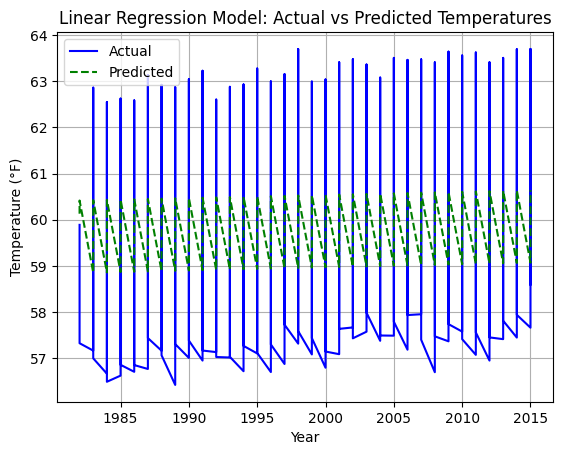

In [ ]:
# final model evaluation
lr_MAE = mean_absolute_error(y_test, y_pred_lr)
lr_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_R2 = r2_score(y_test, y_pred_lr)

# need to get closer to 0
print("MSE:", mean_squared_error(y_test, y_pred_lr))

# need to get closer to 1
print("R2 Score:", lr_R2)

plt.plot(X_test['year'], y_test, label='Actual', color='blue')
plt.plot(X_test['year'], y_pred_lr, label='Predicted', linestyle='--', color='green')
plt.xlabel("Year")
plt.ylabel("Temperature (°F)")
plt.title("Linear Regression Model: Actual vs Predicted Temperatures")
plt.legend()
plt.grid(True)
plt.show()

Training Linear Regression with Poly Features...
Training completed in 3173.16 seconds

Polynomial Regression Model Evaluation:
Root Mean Squared Error (RMSE):  0.7019860894188222
Mean Absolute Error (MAE):  0.568883202454079
R-Squared:  0.8993068524649953
Polynomial Regression - Mean CV Score: -0.5647152101574726


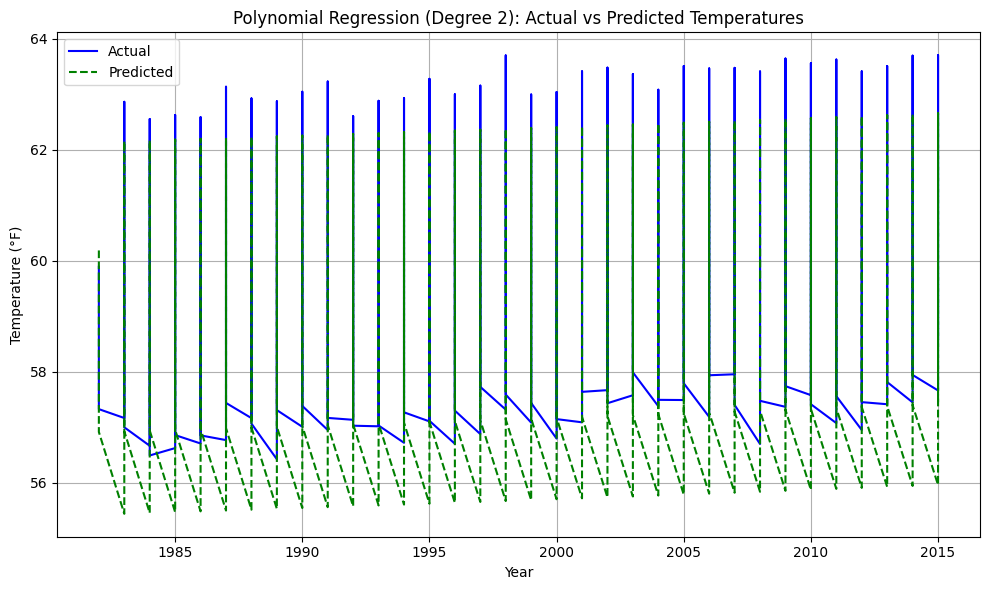

In [ ]:
# Trying to imlement Polynomial Regression (Linear Regression with Polynomial Features) to improve performance
# define poly model, piplining linear to poly
poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
print("Training Linear Regression with Poly Features...")
# give training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

poly_model.fit(X_train, y_train)

# make predictions
y_pred_poly = poly_model.predict(X_test)

# poly model evaluation
poly_MSE = mean_squared_error(y_test, y_pred_poly)
poly_RMSE = np.sqrt(poly_MSE)
poly_MAE = mean_absolute_error(y_test, y_pred_poly)
poly_R2 = r2_score(y_test, y_pred_poly)

print("\nPolynomial Regression Model Evaluation:")
print("Root Mean Squared Error (RMSE): ", poly_RMSE)
print("Mean Absolute Error (MAE): ", poly_MAE)
print("R-Squared: ", poly_R2)

# implementing k-fold cross-validation
poly_cv_scores = cross_val_score(poly_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Polynomial Regression - Mean CV Score: {np.mean(poly_cv_scores)}")

# plotting actual vs predicted temps
plt.figure(figsize=(10,6))
plt.plot(X_test['year'], y_test, label="Actual", color='blue')
plt.plot(X_test['year'], y_pred_poly, label="Predicted", color='green', linestyle='--')
plt.title("Polynomial Regression (Degree 2): Actual vs Predicted Temperatures")
plt.xlabel("Year")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
"""
Model Comparison Plots
"""
results_df = pd.DataFrame({
    "Model": ["SVR", "Random Forest", "Linear Regression"],
    "MAE": [svr_MAE, rf_MAE, poly_MAE],
    "RMSE": [svr_RMSE, rf_RMSE, poly_RMSE],
    "R² Score": [svr_R2, rf_R2, poly_R2]
})

print(results_df)


               Model       MAE      RMSE  R² Score
0                SVR  0.424168  0.572517  0.933024
1      Random Forest  0.534175  0.631698  0.918462
2  Linear Regression  0.568883  0.701986  0.899307
